In [1]:
import tensorflow as tf

2022-06-26 17:54:04.769568: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
import os

In [5]:
# Classes
num_classes = 2

# Epochs
n_epochs = 10

# Tamanho imagem
img_rows, img_cols = 128, 128

input_shape = (img_rows, img_cols, 3)

#Batch size

batch_size = 32

# seed
seed=42

path_dataset = Path('/scratch/dpfurtado/pilheira_new_home/segmentacao/dataset/')
path_test = path_dataset/'test_1_2'/'JPEGImages'
path_test_mask = path_dataset/'test_1_2'/'SegmentationClassPNG_binario'

In [6]:
from PIL import Image
import glob
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [7]:
#Capture training image info as a list
test_images = []

image_names_test = glob.glob(str(path_test/'*.jpg'))
image_names_test.sort()

for img_path in image_names_test:
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize((img_rows, img_cols))
    img = np.array(img)
    img = preprocess_input(img)
    test_images.append(img)
       
#Convert list to array for machine learning processing        
test_images = np.array(test_images)

In [8]:
test_images.shape

(341, 128, 128, 3)

In [9]:
#Capture training image info as a list
masks = []

mask_names_test = glob.glob(str(path_test_mask/'*.png'))
mask_names_test.sort()

for img_path in mask_names_test:
    img = Image.open(img_path)
    img = img.resize((img_rows, img_cols))
    img = np.array(img)
    masks.append(img)
       
#Convert list to array for machine learning processing        
mask_dataset = np.array(masks)

In [10]:
mask_dataset.shape

(341, 128, 128)

In [11]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, mask_dataset))

2022-06-26 17:54:15.364772: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-26 17:54:15.368789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-26 17:54:16.278318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-06-26 17:54:16.278855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce GTX TITAN Black computeCapability: 3.5
coreClock: 0.98GHz coreCount: 15 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 312.92GiB/s
2022-06-26 17:54:16.278896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [12]:
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [14]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Imagem Original', 'Mapa de Segmentação', 'Mapa de Segmentação (Predito)']
    
    for i in range(len(display_list)):
        raw = display_list[i].numpy()
        convert = (raw+1)/2
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(convert)
        plt.axis('off')
    plt.show()

In [16]:
model = tf.keras.models.load_model('./model/pix2pix')

In [17]:
predictions = model.predict(test_dataset)

2022-06-26 17:54:28.201381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-26 17:54:28.228871: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-06-26 17:54:28.544736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-06-26 17:54:29.397279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


In [18]:
predictions_arg = tf.argmax(predictions, axis=-1)
predictions_arg = predictions_arg.numpy().astype(int)

In [19]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(mask_dataset, predictions_arg)
m.result().numpy()

0.7032484

In [20]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(mask_dataset, predictions_arg)
m.result().numpy()

0.8569218

In [21]:
for i in range(len(predictions_arg)):
    nome = os.path.basename(mask_names_test[i])
    path_img_mask = './mask_pred/' + nome 
    plt.imsave(path_img_mask, predictions_arg[i])

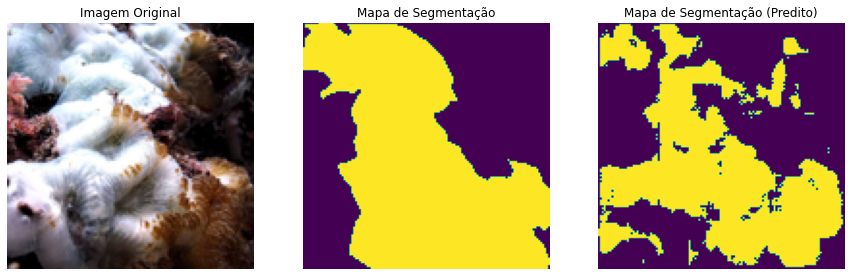

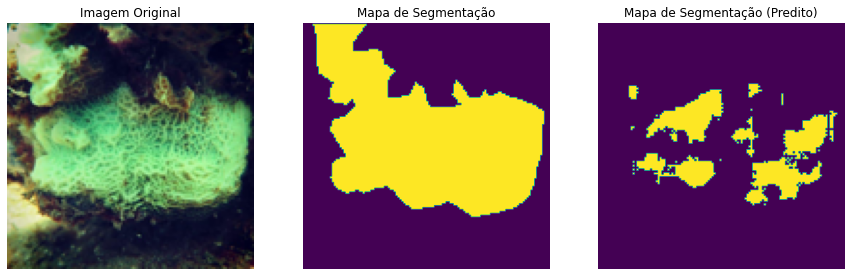

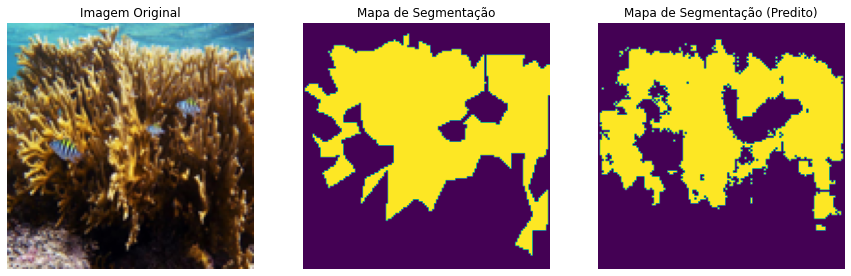

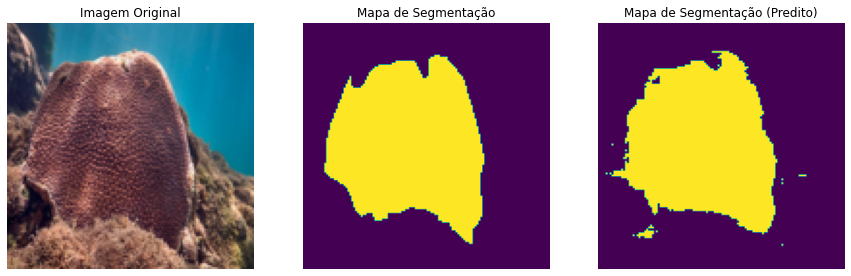

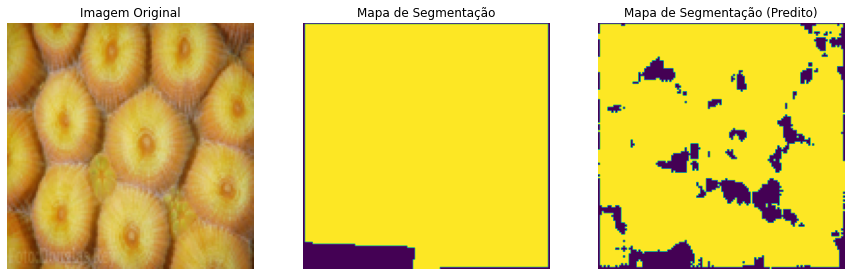

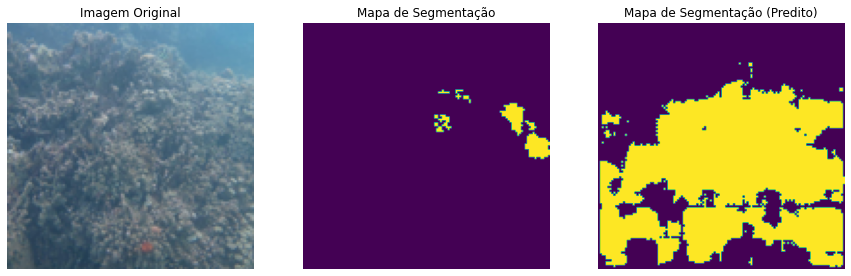

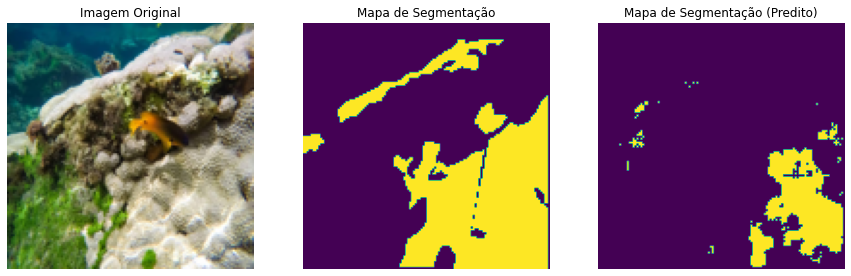

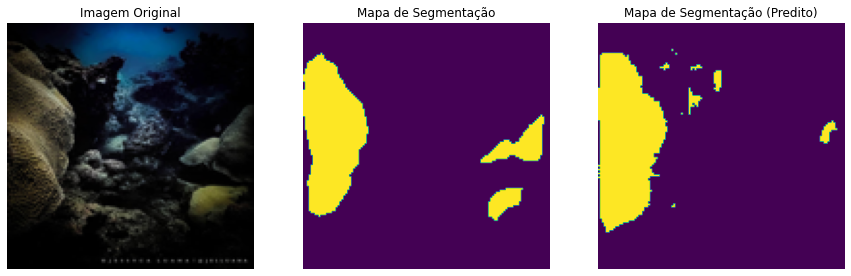

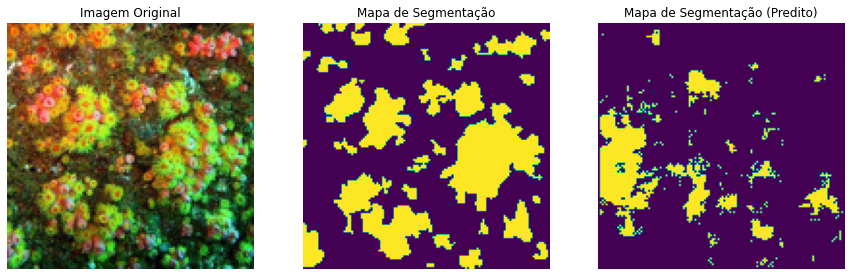

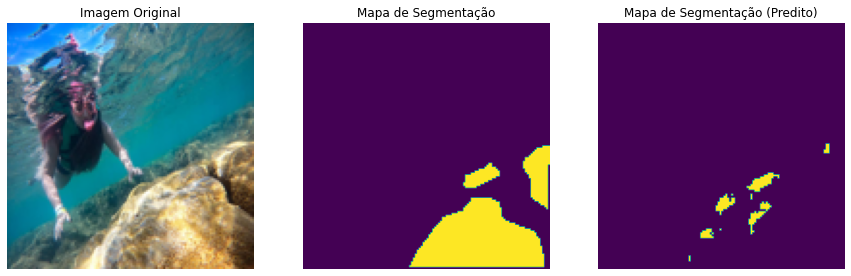

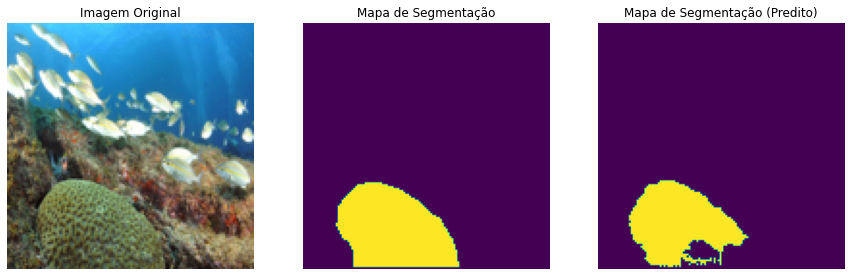

In [22]:
show_predictions(test_dataset, 150)